In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
from PIL import Image

(225, 225)


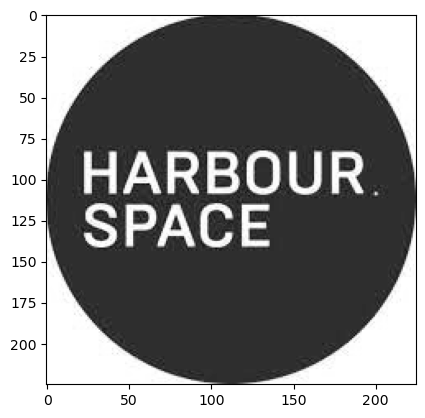

In [3]:
img = Image.open('image.png').convert("L")

img_np = np.array(img)

print(img_np.shape)

plt.imshow(img_np, cmap='gray')
plt.show()

### Apply DFT To The Image


#####  DFT For 2D
$$
F(u, v) = \sum_{x=0}^{M-1} \sum_{y=0}^{N-1} f(x, y) \cdot e^{-j 2 \pi \left( \frac{u x}{M} + \frac{v y}{N} \right)}
$$


##### DFT For 1D 


$$
F(u) = \sum_{x=0}^{N-1} f(x) \cdot e^{-j 2 \pi \frac{u x}{N}}
$$

In [4]:
def dft_matrix(N):
    u = np.arange(N)
    x = u.reshape((N, 1))
    # Exponent for the DFT matrix
    exponent = -2j * np.pi * x * u / N
    # DFT matrix
    W = np.exp(exponent)
    return W


def generate_dft(img_np):
    M, N = img_np.shape

    # Create DFT matrices for rows and columns
    W_M = dft_matrix(M)
    W_N = dft_matrix(N)

    # Apply DFT on rows, then on columns
    dft_result = np.dot(W_M, img_np)
    dft_result = np.dot(dft_result, W_N)

    return dft_result

dft_result = generate_dft(img_np)

### Calculate Spectrum

$$
\text{Magnitude Spectrum} = \log\left( |F(u, v)| + 1 \right)
$$


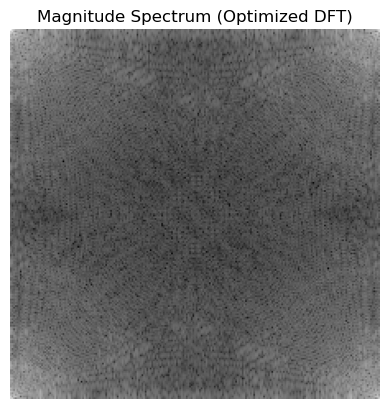

In [5]:
magnitude_spectrum = np.log(np.abs(dft_result) + 1)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum (Optimized DFT)')
plt.axis('off')
plt.show()

### Flattening The Array, and Finding Threshold


$$
|F(u, v)| = \sqrt{\text{Re}^2 + \text{Im}^2}
$$


In [6]:
def compress_img(dft, compression_rate = 0.1):
    # Flatten the 2D DFT result and calculate magnitudes
    magnitudes = [abs(value) for row in dft for value in row]

    # Sort the magnitudes in ascending order
    sorted_magnitudes = sorted(magnitudes)

    # Calculate the index for the desired quantile
    quantile_index = int(len(sorted_magnitudes) * (1 - compression_rate))

    # Get the threshold value
    threshold = sorted_magnitudes[quantile_index]

    # Apply the threshold to the original 2D DFT result
    dft_compressed = [
        [value if abs(value) > threshold else 0 for value in row] for row in dft_result]

    # Convert back to a NumPy array for further processing
    dft_compressed = np.array(dft_compressed, dtype=complex)

    return dft_compressed


dft_compressed = compress_img(dft_result, compression_rate=0.01)

#### Reorder The DFT Signal Back To Original Order


In [7]:
dft_ishifted = np.fft.ifftshift(dft_compressed)

#### Calculate Inverse DFT Matrix

$$
W_N = \left[ e^{j \frac{2 \pi}{N} uv} \right]
$$


#### Apply Inverse DFT 

$$
f(x) = \frac{1}{N} \sum_{u=0}^{N-1} F(u) \cdot e^{j \frac{2 \pi}{N} ux}
$$


In [8]:
def inverse_dft_matrix(N):
    u = np.arange(N)
    x = u.reshape((N, 1))
    # Exponent for the IDFT matrix
    exponent = 2j * np.pi * x * u / N
    # IDFT matrix
    W = np.exp(exponent)
    return W / N  # Normalization factor for IDFT


def apply_inverse_dft(dft_ishifted):
    """
    Optimized Inverse 2D DFT using matrix multiplication.
    """
    M, N = dft_ishifted.shape

    # Create IDFT matrices for rows and columns
    W_M = inverse_dft_matrix(M)
    W_N = inverse_dft_matrix(N)

    # Apply IDFT on columns first, then rows
    intermediate = np.dot(W_M, dft_ishifted)
    reconstructed_image = np.dot(intermediate, W_N)

    # Return the magnitude since the result is complex
    return np.abs(reconstructed_image)

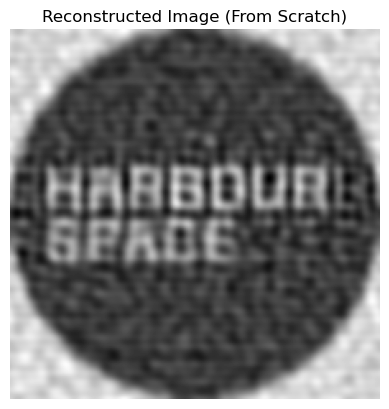

In [9]:
# Step 2: Manual Inverse 2D DFT
reconstructed_image = apply_inverse_dft(dft_ishifted)

# Display the reconstructed image
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Reconstructed Image (From Scratch)')
plt.axis('off')
plt.show()

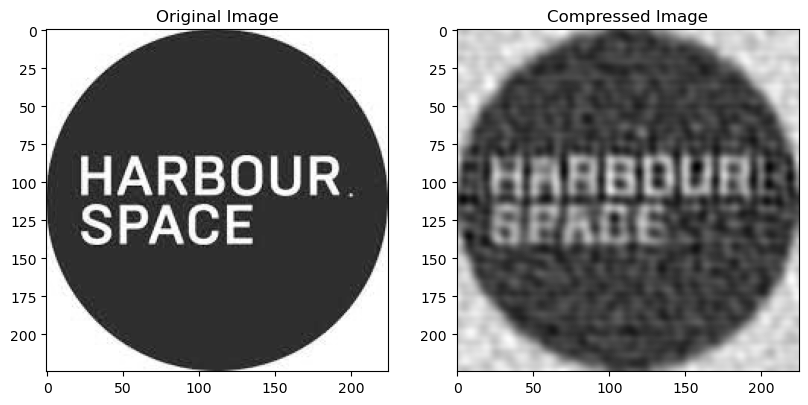

In [10]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 2)
plt.title("Original Image")
plt.imshow(img_np, cmap='gray')

plt.subplot(1, 3, 3)
plt.title(f"Compressed Image")
plt.imshow(reconstructed_image, cmap='gray')

plt.show()